In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!pip install mne

In [ ]:
from mne.datasets.sleep_physionet.age import fetch_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Input, BatchNormalization, UpSampling1D, MaxPooling1D, Flatten, Dense, LeakyReLU, Conv1D, Reshape, Add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
import mne
import numpy as np
import csv
import os
from tensorflow.keras import backend as K

In [ ]:
def build_dataset(no_of_people=30):
  dataset = {'x': [], 'y':[]}
  people = [i for i in range(no_of_people)]
  remove_people = [36, 39, 52, 68, 69, 78, 79]
  for j in remove_people:
    try:
      people.remove(j)
    except ValueError:
      pass

  sf = 100
  annotation_desc_2_event_id = {'Sleep stage W': 1}
  event_id = {'Sleep stage W': 1}
  
  tmax = 30. - 1. / sf
  
  files = fetch_data(subjects=people, recording=[1])
  
  count = 0
        
  for file in files:
    temp_X = []
    temp_Y = []  
    raw = mne.io.read_raw_edf(file[0])
    annot = mne.read_annotations(file[1])
    raw.set_annotations(annot, emit_warning=False)
    events, _ = mne.events_from_annotations(
        raw, event_id=annotation_desc_2_event_id, chunk_duration=30.)
    epochs = mne.Epochs(raw=raw, events=events,
                              event_id=event_id, tmin=0., tmax=tmax, baseline=None)
    print("Subject No: ", count)
    count += 1
    if count == 1:
      x = (epochs.get_data(picks="eeg"))[:,0,:]
      y = epochs.events[:, 2]
      for i in range(y.shape[0]):
        if y[i] == 1:
          temp_Y.append(count)
          temp_X.append(x[i,:])
      X = np.array(temp_X)
      Y = np.array(temp_Y)
      
    else:
      x = (epochs.get_data(picks="eeg"))[:,0,:]
      y = epochs.events[:, 2]
      for i in range(y.shape[0]):
        if y[i] == 1:
          temp_Y.append(count)
          temp_X.append(x[i,:])
      X = np.concatenate((X, np.array(temp_X)), axis=0)
      Y = np.concatenate((Y, np.array(temp_Y)), axis=0)
      
  #X = (epochs_test.get_data(picks="eeg"))[:,0,:]
  #Y = epochs_test.events[:, 2]
  dataset['x'] = X
  dataset['y'] = Y
  return dataset

In [ ]:
def normalize_vector(vector):
  normalized_vector = (vector - vector.min()) / (vector.max() - vector.min())
  return normalized_vector

In [ ]:
dataset = build_dataset(60)

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage W']
Not setting metadata
Not setting metadata
1997 matching events found
No baseline correction applied
0 projection items activated
Subject No:  0
Loading data for 1997 events and 3000 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage W']
Not setting metadata
Not setting metadata
1856 matching events found
No baseline correction applied
0 projection items activated
Subject No:  1
Loading data for 1856 events and 3000 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /root/mne_data/phy

In [ ]:
print(dataset['x'].shape, dataset['x'].dtype)
print(dataset['y'].shape, dataset['y'].dtype)

(107600, 3000) float64
(107600,) int64


In [ ]:
def preprocess_dataset(dataset, test_size=0.1, val_size=0.2):
  x = np.array([normalize_vector(i) for i in dataset['x']], dtype=np.float)
  x = np.reshape(x, (x.shape[0], x.shape[1], 1))
  y = np.array(dataset['y'], dtype=np.uint8)

  # ohe = OneHotEncoder()
  # y = ohe.fit_transform(y.reshape((-1,1))).toarray()
  
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, random_state=42)

  print(x_train.shape, y_train.shape)
  print(x_val.shape, y_val.shape)
  print(x_test.shape, y_test.shape)

  return x_train, x_val, x_test, y_train, y_val, y_test

In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test = preprocess_dataset(dataset, 0.2, 0.3)

(60256, 3000, 1) (60256,)
(25824, 3000, 1) (25824,)
(21520, 3000, 1) (21520,)


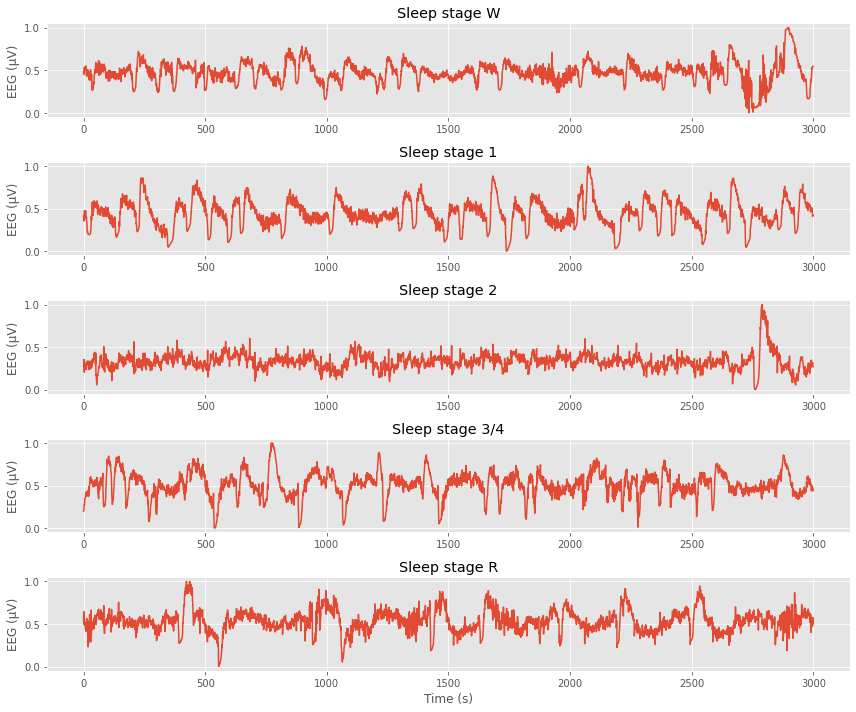

In [ ]:
plt.style.use('ggplot')
fig = plt.figure(figsize=[12, 10])

fig.add_subplot(5,1,1)
plt.plot(x_train[30643])
plt.ylabel('EEG (μV)')
plt.title("Sleep stage W")

fig.add_subplot(5,1,2)
plt.plot(x_train[30644])
plt.ylabel('EEG (μV)')
plt.title("Sleep stage 1")

fig.add_subplot(5,1,3)
plt.plot(x_train[30642])
plt.ylabel('EEG (μV)')
plt.title("Sleep stage 2")

fig.add_subplot(5,1,4)
plt.plot(x_train[30646])
plt.ylabel('EEG (μV)')
plt.title("Sleep stage 3/4")

fig.add_subplot(5,1,5)
plt.plot(x_train[30637])
plt.xlabel('Time (s)')
plt.ylabel('EEG (μV)')
plt.title("Sleep stage R")

plt.tight_layout()
plt.show()

In [ ]:
def residual_block_a(input, no_of_filters, kernel_size=3):
  x_short = Conv1D(filters=no_of_filters, kernel_size=1, padding="same")(input)
  x_short = BatchNormalization()(x_short)

  x = Conv1D(filters=no_of_filters, kernel_size=kernel_size, padding="same")(input)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  x = Conv1D(filters=no_of_filters, kernel_size=kernel_size, padding="same")(x)
  x = BatchNormalization()(x)

  x_add = Add()([x_short, x])
  x_out = LeakyReLU(alpha=0.2)(x_add)

  return x_out

In [ ]:
def residual_block_a(input, no_of_filters, kernel_size=3):
  x_short = Conv1D(filters=no_of_filters, kernel_size=1, padding="same")(input)
  x_short = BatchNormalization()(x_short)

  x = Conv1D(filters=no_of_filters, kernel_size=kernel_size, padding="same")(input)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  x = Conv1D(filters=no_of_filters, kernel_size=kernel_size, padding="same")(x)
  x = BatchNormalization()(x)

  x_add = Add()([x_short, x])
  x_out = LeakyReLU(alpha=0.2)(x_add)

  return x_out

In [ ]:
def residual_block_b(input, no_of_filters, kernel_size=3):
  x = UpSampling1D(size=2)(input)

  # x_short = Conv1D(filters=no_of_filters, kernel_size=1, padding="same")(x)
  # x_short = BatchNormalization()(x_short)

  x = Conv1D(filters=no_of_filters, kernel_size=kernel_size, padding="same")(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  x = Conv1D(filters=no_of_filters, kernel_size=kernel_size, padding="same")(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  # x_add = Add()([x_short, x])
  x_out = LeakyReLU(alpha=0.2)(x)

  return x_out

In [ ]:
def build_model(time_steps, features, latent_dim=128):
  i = Input(shape=(time_steps, features))
  
  x1 = residual_block_a(i, 16, 3)
  x1 = MaxPooling1D(pool_size=2)(x1)

  x2 = residual_block_a(x1, 32, 3)
  x2 = MaxPooling1D(pool_size=2)(x2)

  x3 = residual_block_a(x2, 64, 3)
  x3 = MaxPooling1D(pool_size=2)(x3)

  x4 = residual_block_a(x3, 128, 3)

  volume_size = K.int_shape(x4)
  x = Flatten()(x4)
  latent = Dense(latent_dim)(x)
  print(latent.shape)

  encoder = Model(i, latent, name="encoder")

  latent_inputs = Input(shape=(latent_dim,))
  x = Dense(np.prod(volume_size[1:]))(latent_inputs)
  x = Reshape((volume_size[1], volume_size[2]))(x)
  
  x5 = residual_block_b(x, 64, 3)

  x6 = residual_block_b(x5, 32, 3)

  x7 = residual_block_b(x6, 16, 3)

  o = Conv1D(features, 3, activation='sigmoid', padding='same')(x7)

  decoder = Model(latent_inputs, o, name="decoder")

  autoencoder = Model(i, decoder(encoder(i)), name="autoencoder")
  return (encoder, decoder, autoencoder)

In [ ]:
(encoder, decoder, autoencoder) = build_model(3000, 1, 512)
autoencoder.summary()

(None, 512)
Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 3000, 1)]         0         
_________________________________________________________________
encoder (Functional)         (None, 512)               24688464  
_________________________________________________________________
decoder (Functional)         (None, 3000, 1)           24673553  
Total params: 49,362,017
Trainable params: 49,360,129
Non-trainable params: 1,888
_________________________________________________________________


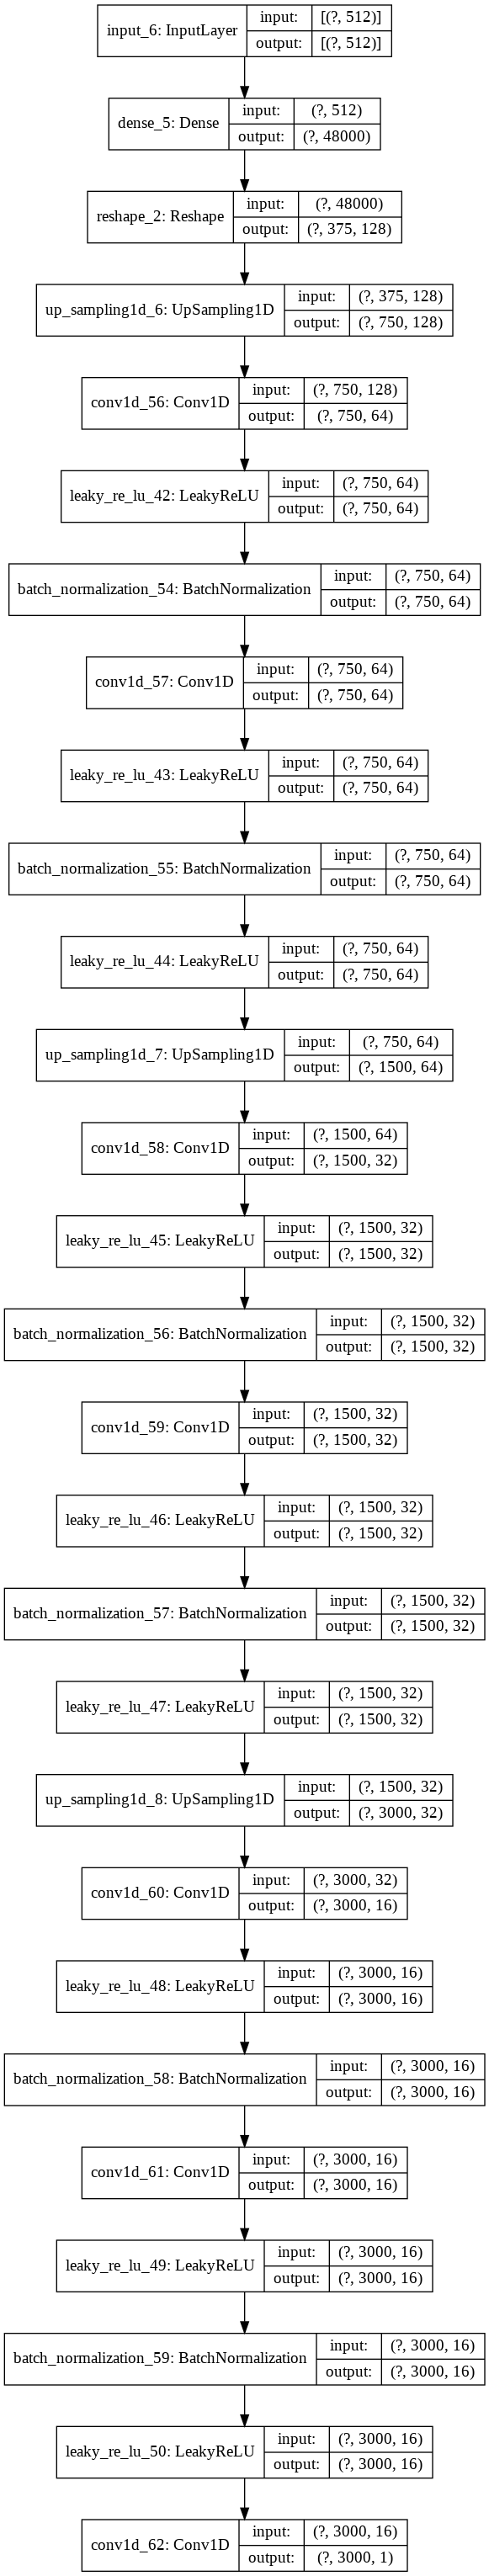

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(encoder, to_file='./encoder.png', show_shapes=True, show_layer_names=True)
plot_model(decoder, to_file='./decoder.png', show_shapes=True, show_layer_names=True)
# plot_model(autoencoder, to_file='./autoencoder.png', show_shapes=True, show_layer_names=True)

In [ ]:
INIT_LR = 0.0005
EPOCHS = 10
BATCH_SIZE = 16
STEPS_PER_EPOCH = x_train.shape[0] // BATCH_SIZE
VALIDATION_STEPS = x_val.shape[0] // BATCH_SIZE

def poly_decay(epoch):
  maxEpochs = EPOCHS
  baseLR = INIT_LR
  power = 1.0

  alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
  return alpha

callbacks = [LearningRateScheduler(poly_decay)]

In [ ]:
def acc(y_true, y_pred):
  return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

def root_mean_squared_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true)))

opt = Adam(lr=INIT_LR, amsgrad=True)

In [ ]:
autoencoder.compile(loss=root_mean_squared_error, optimizer=opt, metrics=[acc])

In [ ]:
r = autoencoder.fit(
  x_train, x_train,
  validation_data=(x_val, x_val),
  epochs=EPOCHS, batch_size=BATCH_SIZE,
  callbacks=callbacks
)

Epoch 1/10
3766/3766 [==============================] - 234s 62ms/step - loss: 0.0739 - acc: 0.8378 - val_loss: 0.0603 - val_acc: 0.8752
Epoch 2/10
3766/3766 [==============================] - 226s 60ms/step - loss: 0.0609 - acc: 0.8689 - val_loss: 0.0575 - val_acc: 0.8834
Epoch 3/10
3766/3766 [==============================] - 225s 60ms/step - loss: 0.0592 - acc: 0.8735 - val_loss: 0.0574 - val_acc: 0.8846
Epoch 4/10
3766/3766 [==============================] - 226s 60ms/step - loss: 0.0585 - acc: 0.8762 - val_loss: 0.0583 - val_acc: 0.8864
Epoch 5/10
3766/3766 [==============================] - 226s 60ms/step - loss: 0.0571 - acc: 0.8826 - val_loss: 0.0580 - val_acc: 0.8881
Epoch 6/10
3766/3766 [==============================] - 222s 59ms/step - loss: 0.0559 - acc: 0.8874 - val_loss: 0.0557 - val_acc: 0.8905
Epoch 7/10
3766/3766 [==============================] - 226s 60ms/step - loss: 0.0553 - acc: 0.8896 - val_loss: 0.0549 - val_acc: 0.8917
Epoch 8/10
3766/3766 [===================

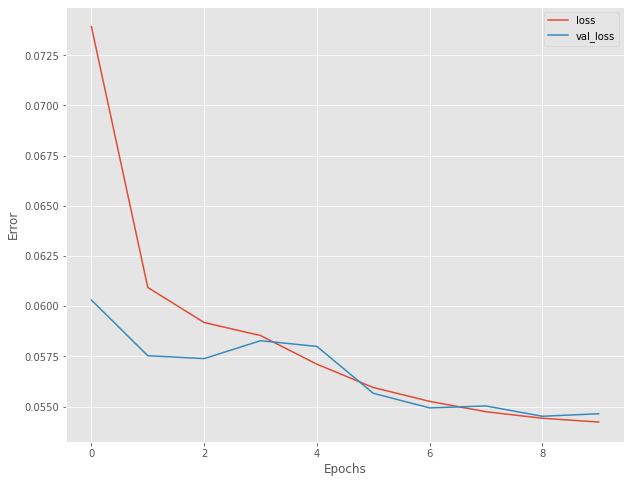

In [ ]:
  plt.figure(figsize=[10,8])
plt.style.use('ggplot')

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')

plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend(loc='best')
plt.show()

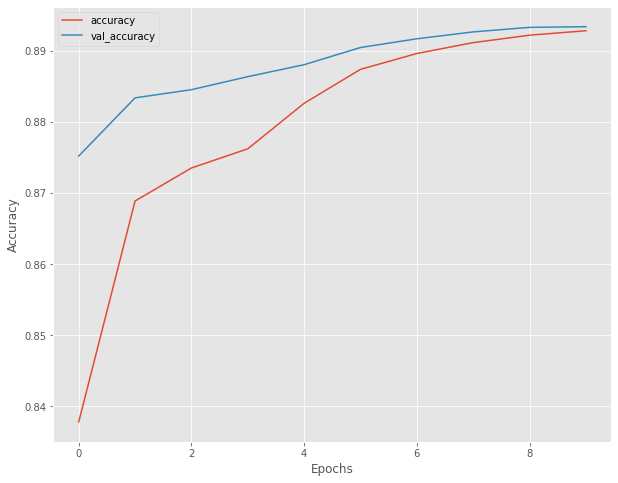

In [ ]:
plt.figure(figsize=[10,8])
plt.style.use('ggplot')

plt.plot(r.history['acc'], label='accuracy')
plt.plot(r.history['val_acc'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

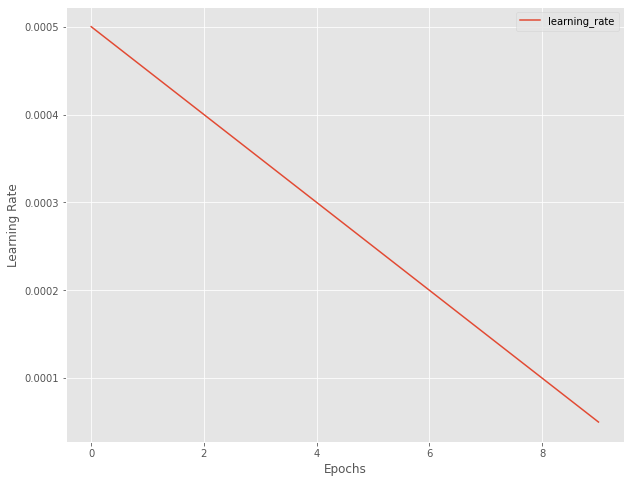

In [ ]:
plt.figure(figsize=[10,8])
plt.style.use('ggplot')

plt.plot(r.history['lr'], label='learning_rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend(loc='best')
plt.show()

In [ ]:
print(autoencoder.evaluate(x_test, x_test, batch_size=BATCH_SIZE))

1345/1345 [==============================] - 10s 8ms/step - loss: 0.0542 - acc: 0.8933
[0.05421822518110275, 0.8932526707649231]


In [ ]:
preds = autoencoder.predict(x_test)
print(preds.shape)

(21520, 3000, 1)


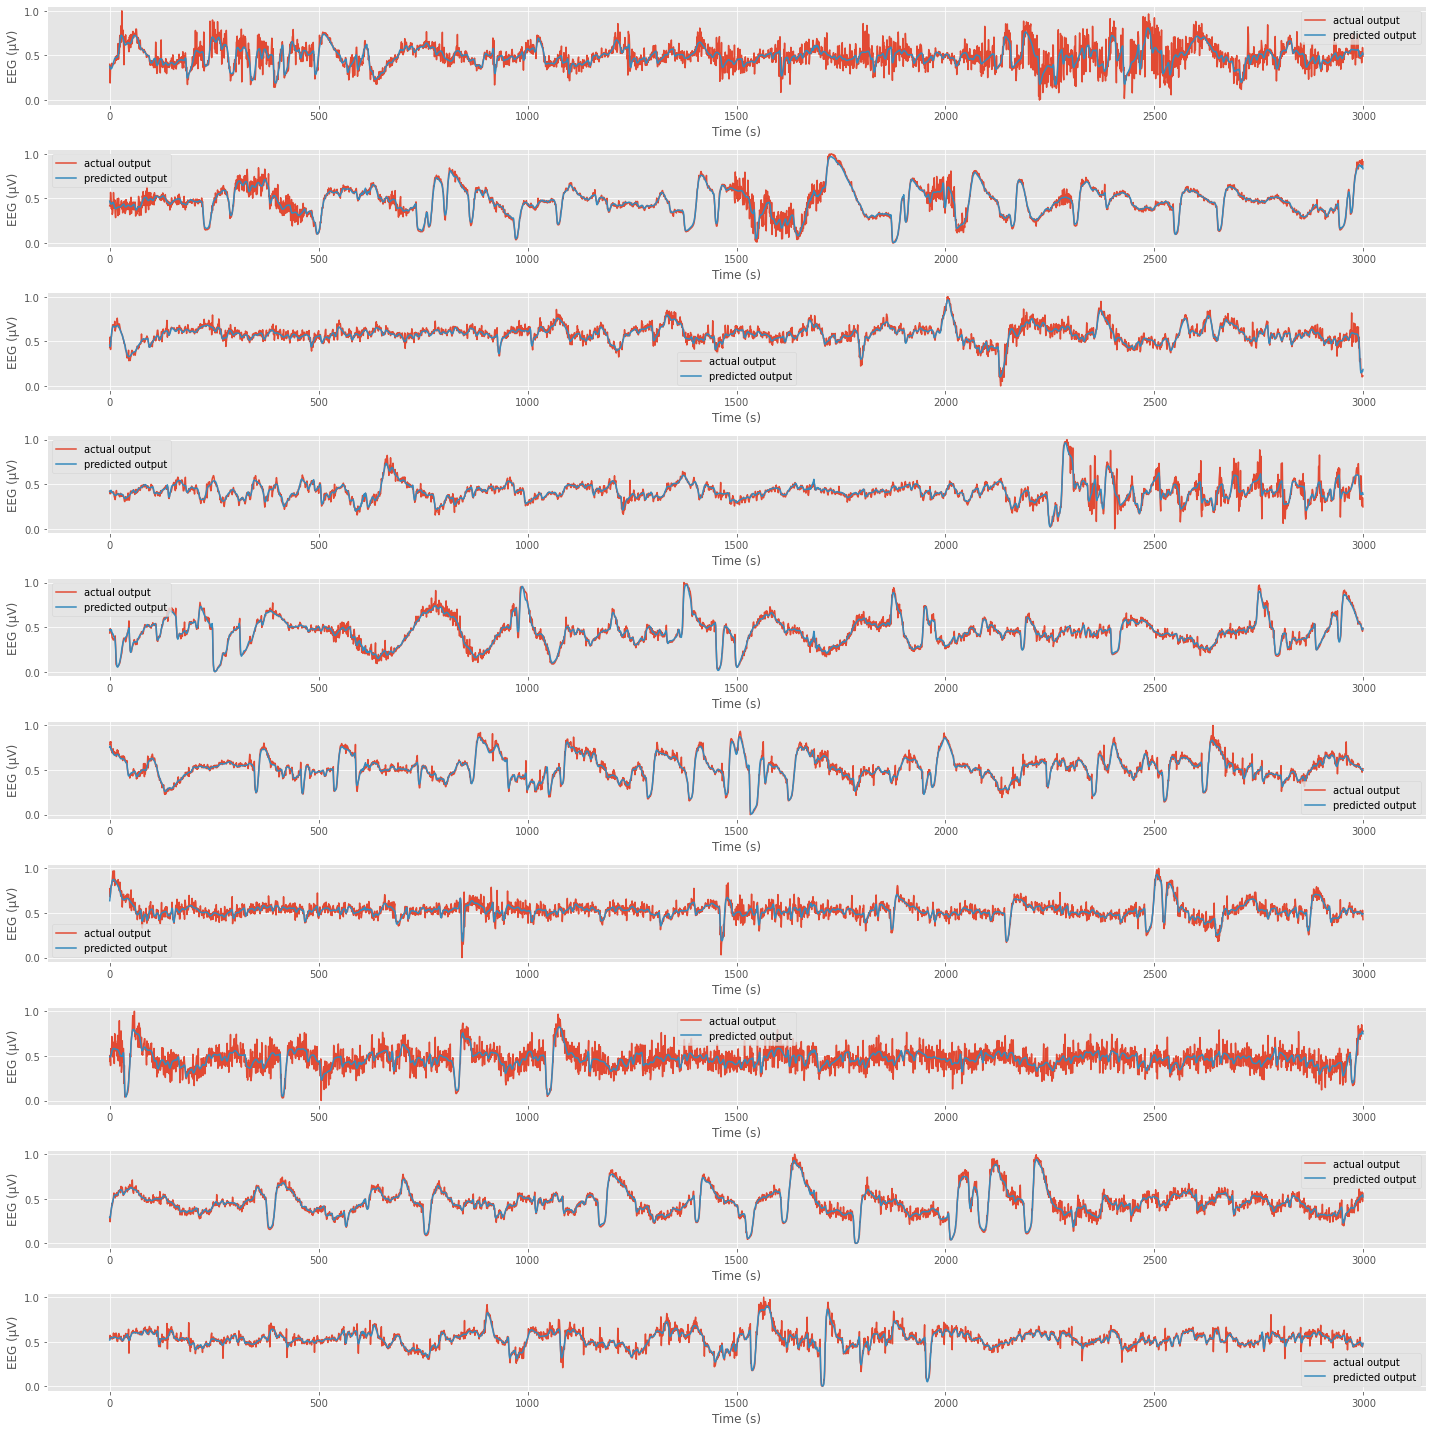

In [ ]:
x = 10

preds_index = np.random.randint(0, x_test.shape[0], x)

plt.style.use('ggplot')
fig = plt.figure(figsize=[20, 20])

for i,v in enumerate(preds_index):
  fig.add_subplot(x,1,i+1)
  plt.plot(x_test[v], label="actual output")
  plt.plot(preds[v], label="predicted output")
  plt.ylabel('EEG (μV)')
  plt.xlabel('Time (s)')
  plt.legend(loc="best")

plt.tight_layout()
plt.show()